In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy

from utils.simulation import *
from utils.mutual import compute_mutual_information
from utils.plotting import *

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
@njit
def theo_mean(w, k, h):
    ### Compute expected average
    beta = 1 + w*(k-1)

    xplus = (h[0] + w*k*(h[0]-h[1])) / beta
    xminus = (h[1] + w*(h[0]-h[1])) / beta
    return np.array( [xplus, xminus] )

@njit
def theo_sigma(w, k):
    ### Compute expected covariance matrix
    tt = 2*(1+w*(k-1))*(2+w*(k-1))
    sigma = np.array([[2+w*(-1+k*(3 + 2*k*w)), w+k*w*(2*w-1)],[w+k*w*(2*w-1), 2+w*(-3+k+2*w)]])
    
    return sigma / tt

@njit
def theo_W_factor(w, k):
    return (2 + (-1 + k)*w) * (2 + (-1+3*k)*w + (1+k**2)*w**2) / (1 + (-1+k)*w) / (2 + 2*(-1+k)*w +(1+k**2)*w**2)

@njit
def tmp_factor(w, k, h1, h2):
    mu1 = theo_mean(w, k, h1)
    mu2 = theo_mean(w, k, h2)
    sigma = theo_sigma(w, k)
    
    return (mu1-mu2).T @ np.linalg.inv(sigma) @ (mu1 - mu2)

@njit
def kl(w, k, h1, h2):
    return tmp_factor(w, k, h1, h2) / 2

@njit
def ch(w, k, h1, h2):
    return tmp_factor(w, k, h1, h2) / 8

@njit
def theo_bound(w, k, pi, hs, which):
    '''
    WARNING: valid only for the case of input to inhibitory = 0
    '''
    if which == 'lb':
        factor = 1 / 8
    elif which == 'ub':
        factor = 1 / 2
        
    factor *= theo_W_factor(w, k)
    
    n_inputs = len(pi)
    
    ress = 0
    for idx_i in range(n_inputs):
        tmp = 0
        for idx_j in range(n_inputs):
            tmp += pi[idx_j] * np.exp( -factor*(hs[0,idx_i]-hs[0,idx_j])**2 )
        ress += pi[idx_i] * np.log( tmp )
    return - ress
    
def theo_lb(w, k, pi, hs):
    n_inputs = len(pi)
    
    ress = 0
    for idx_i in range(n_inputs):
        tmp = 0
        for idx_j in range(n_inputs):
            tmp += pi[idx_j] * np.exp( -ch(w, k, hs[:,idx_i],hs[:,idx_j]) )
        ress += pi[idx_i] * np.log( tmp )
    return - ress

def theo_ub(w, k, pi, hs):
    n_inputs = len(pi)

    ress = 0
    for idx_i in range(n_inputs):
        tmp = 0
        for idx_j in range(n_inputs):
            tmp += pi[idx_j] * np.exp( -kl(w, k, hs[:,idx_i],hs[:,idx_j]) )
        ress += pi[idx_i] * np.log( tmp )
    return - ress

In [3]:
def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r}

# Figure 1 - Role of timescales

### Example of trajectory for slow timescale

In [4]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 3
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [ ]:
### Simulate state
inputs_slow, states_slow = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)

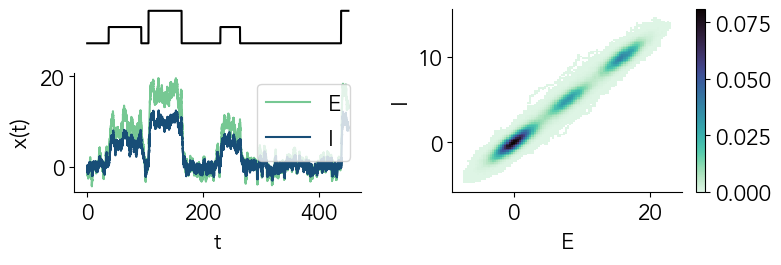

In [42]:
### Plot simulation
plot_simulation(states_slow, inputs_slow, hs[0], dt, fname='fig_1_example_slow', max_steps_to_plot=int(9e4))

### Example of trajectory for fast timescale

In [43]:
### Info input
M = 3
tau_h = 5
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 3
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

### Simulate state
inputs_fast, states_fast = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)

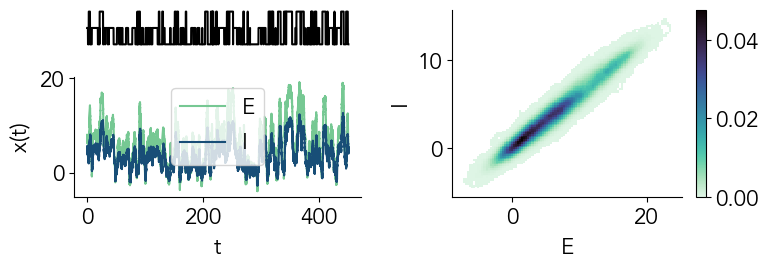

In [45]:
### Plot simulation
plot_simulation(states_fast, inputs_fast, hs[0], dt, fname='fig_1_example_fast', max_steps_to_plot=int(9e4))

### Compute MI by varying tau_h

In [56]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info system - increase w
info_system['w'] = 40

In [66]:
entropy(p_stat), theo_ub(info_system['w'], info_system['k'], p_stat, info_input['hs']), theo_lb(info_system['w'], info_system['k'], p_stat, info_input['hs'])

(1.0397207708399179, 0.9409416720238923, 0.527833163344602)

In [58]:
#taus = np.array( [1, 10, 50, 100, 500, 1000, 2000] )
taus = np.logspace(-1,3,10)
bins = 100

### Info simulation
steps = int(1e7)
dt = 0.01

ress = np.zeros(taus.size)

for idx, tau in enumerate(taus):
    print(f'[*] tau={tau}')
    ### Info input
    wup = 1 / tau
    wdown = 2 / tau

    W = create_transition_matrix_star_graph(M, wup, wdown)
    
    ### Create info dictionaries
    info_input = create_info_input(W, hs)
    info_simulation = create_info_simulation(steps,dt)
    
    ### Simulate state
    inputs, states = simulate_coupled_system(info_system, info_input, info_simulation)
    
    ### Compute MI
    ress[idx] = compute_mutual_information(states, inputs, bins)

[*] tau=0.1
[*] tau=0.2782559402207124
[*] tau=0.774263682681127
[*] tau=2.1544346900318834
[*] tau=5.994842503189409
[*] tau=16.68100537200059
[*] tau=46.41588833612777
[*] tau=129.15496650148827
[*] tau=359.38136638046257
[*] tau=1000.0


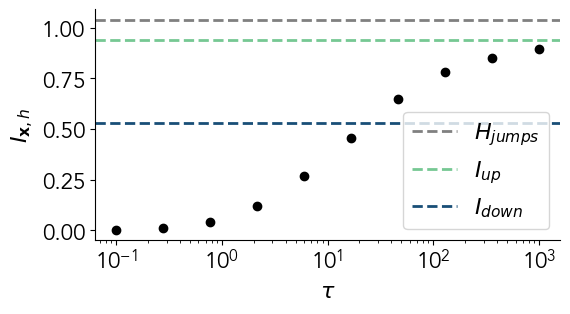

In [63]:
upper_bound = theo_ub(info_system['w'], info_system['k'], p_stat, info_input['hs'])
lower_bound = theo_lb(info_system['w'], info_system['k'], p_stat, info_input['hs'])

lw = 2

plt.figure(figsize=(6,3))
plt.plot(taus, ress, 'o', c='k')
plt.axhline(entropy(p_stat), c='gray', ls='--', lw=lw, label=r'$H_{jumps}$')
plt.axhline(upper_bound, c=colors[0], ls='--', lw=lw, label=r'$I_{up}$')
plt.axhline(lower_bound, c=colors[1], ls='--', lw=lw, label=r'$I_{down}$')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$I_{\mathbf{x},h}$')
plt.legend()
sns.despine()
plt.show()

# Figure 2 - Edge of stability

In [5]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 0.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info system - increase w
info_system['w'] = 40

In [10]:
#kmin, kmax = 0.1, 2.
#wmin, wmax = 0.5, 100

kmin, kmax = 0., 1.5
wmin, wmax = 0.01, 10

nk, nw = int(5e2), int(5e2)

ks, ws = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

Ks, Ws = np.meshgrid(ks, ws)

unstable = np.where(1 + Ws*(Ks-1)<=0)

Z = theo_W_factor(Ws, Ks)
Z[unstable] = np.nan

lbs = np.zeros(Ks.shape)
ubs = np.zeros(Ks.shape)

for (idx_x, idx_y) in np.ndindex(Ks.shape):
    if np.isnan(Z[idx_x, idx_y]):
        continue
    w, k = Ws[idx_x, idx_y], Ks[idx_x, idx_y]
    lbs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'lb')
    ubs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'ub')
    
lbs[unstable] = np.nan
ubs[unstable] = np.nan

print(entropy(p_stat), np.nanmax(ubs), np.nanmax(lbs), np.nanmax(Z))

1.0397207708399179 1.0397207708399179 1.0397207708399179 92922.67644879733


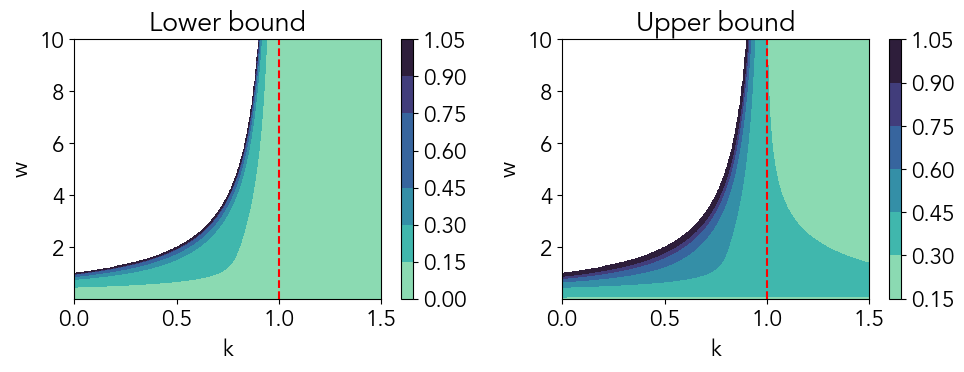

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.contourf(Ks, Ws, lbs, cmap=my_cmap) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Lower bound')

plt.subplot(1,2,2)
plt.contourf(Ks, Ws, ubs, cmap=my_cmap) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Upper bound')

plt.tight_layout()
plt.show()

In [29]:
np.log(wmax)

6.907755278982137

In [38]:
#kmin, kmax = 0.1, 2.
#wmin, wmax = 0.5, 100

kmin, kmax = 0.99, 1.
wmin, wmax = 1, 1e4

nk, nw = int(5e2), int(5e2)

ks, ws = np.linspace(kmin, kmax, nw), np.logspace(np.log10(wmin), np.log10(wmax), nw)

Ks, Ws = np.meshgrid(ks, ws)

unstable = np.where(1 + Ws*(Ks-1)<=0)

Z = theo_W_factor(Ws, Ks)
Z[unstable] = np.nan

lbs = np.zeros(Ks.shape)
ubs = np.zeros(Ks.shape)

for (idx_x, idx_y) in np.ndindex(Ks.shape):
    if np.isnan(Z[idx_x, idx_y]):
        continue
    w, k = Ws[idx_x, idx_y], Ks[idx_x, idx_y]
    lbs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'lb')
    ubs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'ub')
    
lbs[unstable] = np.nan
ubs[unstable] = np.nan

print(entropy(p_stat), np.nanmax(ubs), np.nanmax(lbs), np.nanmax(Z))

1.0397207708399179 1.0397207708399179 1.0397207708399179 34185.12764941856


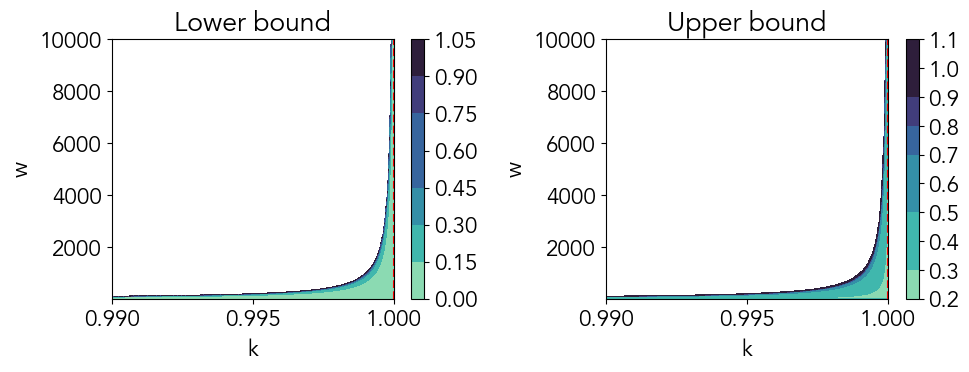

In [39]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.contourf(Ks, Ws, lbs, cmap=my_cmap) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Lower bound')

plt.subplot(1,2,2)
plt.contourf(Ks, Ws, ubs, cmap=my_cmap) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Upper bound')

plt.tight_layout()
plt.show()

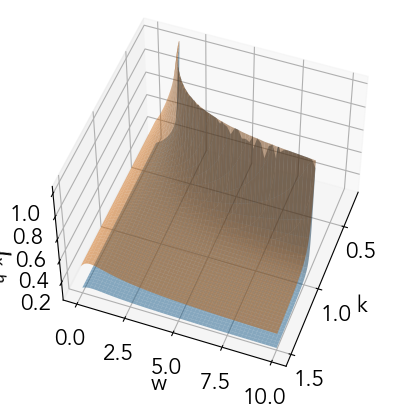

In [76]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

show_lb = True
show_ub = True

if show_lb:
    surf = ax.plot_surface(Ks, Ws, lbs,
                       alpha=0.5,
                       #edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3,
                       #cmap='coolwarm', linewidth=0, antialiased=False
                      )
if show_ub:
    surf = ax.plot_surface(Ks, Ws, ubs,
                           alpha=0.5,
                           #edgecolor='red', lw=0.5, rstride=8, cstride=8, alpha=0.3,
                           #cmap='coolwarm', linewidth=0, antialiased=False
                          )

#ax.contourf(Ws, Ks, ubs, zdir='x', offset=Ws.min(), cmap='coolwarm')
#ax.contourf(Ws, Ks, ubs, zdir='y', offset=Ks.max(), cmap='coolwarm')

ax.set_xlabel('k')
ax.set_ylabel('w')
ax.set_zlabel(r'$I_{x,h}$')

#ax.view_init(elev=50, azim=-140)
ax.view_init(elev=50, azim=20)
#ax.view_init(elev=20, azim=100)
#ax.view_init(elev=20, azim=80)

#plt.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

# Figure 3 - Time dependent